In [1]:
import sys, platform, os
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
# import seaborn as sns

# Global definition of matplotlib plots appearance

plt.rcParams['mathtext.default']= 'regular'
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams["axes.labelpad"]=10             # axes labels distance from tick labels
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.2
plt.rcParams['figure.dpi'] = 400             #  figure dimension in dpi

camb_installation_path = './../' 
camb_path = os.path.realpath(os.path.join(os.getcwd(),camb_installation_path))
sys.path.insert(0,camb_path)
import camb

In [2]:
wBD_list = [10, 30, 100, 1000]
cls_camb_dict = {}
pk_camb_dict = {}
k_camb_dict = {}

phi_i = 1.0

def shoot(lmd, params):
    par = params.copy()
    par['feedback_level'] = 0
    par['Horndeski_shooting'] = True
    par['Horndeskic00'] = 3 * lmd * (par['H0'] * 1e3 / 299792458)**2
    cp = camb.set_params(**par)
    rl = camb.get_background(cp)
    return rl.Params.EFTCAMB_parameter_cache.h0 / par['H0'] - 1


for wBD in wBD_list:
    params_camb = {
        # config
        'lmax': 10000,
        'kmax': 2,
        'lSampleBoost': 2,
        'DoLateRadTruncation': False,
        'use_cl_spline_template': True,
        # cosmology
        'ombh2': 0.022,
        'omch2': 0.12,
        'H0': 44.31,
        'tau': 0.09,
        'ns': 0.9624,
        'As': 2.3e-09,
        'num_massive_neutrinos': 0,
        'mnu': 0,
        'nnu': 3.044,
        'r': 0,
        'nt': 0,
        # MG
        'dark_energy_model': 'EFTCAMB',
        'EFTflag': 5,
        'Horndeski_model': 7,
        'Horndeski_freefunc0_model': 1,
        'Horndeskic00': 3 * 2.068281 * (67.5 * 1e3 / 299792458)**2,
        'Horndeski_freefunc1_model': 0,
        'Horndeski_freefunc2_model': 0,
        'Horndeski_freefunc3_model': 5,
        'Horndeskic3_Taylor_order': 2,
        'Horndeskic3a0': 0,
        'Horndeskic30': -0.5,
        'Horndeskic31': 0,
        'Horndeskic32': 1 / (8 * wBD),
        'Horndeski_freefunc4_model': 0,
        'Horndeski_freefunc5_model': 0,
        'Horndeski_freefunc6_model': 0,
        'Horndeski_parameter_number': 0,
        'Horndeski_model_specific_ic': False,
        'Horndeski_phi_ini': np.sqrt(4 * wBD * phi_i),
        'Horndeski_phidot_ini': 0,
        'Horndeski_evolve_hubble': False,
        'Horndeski_shooting': False,
        'model_background_num_points': 10000,
        'model_background_a_ini': 1e-8,
        'Horndeski_a_pertcutoff_before': 1e-8,
        'EFTCAMB_back_turn_on': 1e-8,
        'EFTCAMB_turn_on_time': 1e-8,
        'EFTCAMB_skip_stability': True,
        'EFTCAMB_skip_RGR': True,
        'EFTCAMB_use_background': True,
        'EFTCAMB_evolve_delta_phi': True,
        'EFTCAMB_evolve_metric_h': False,
        'feedback_level': 3,
    }

    # solve Horndeskic00
    result = root_scalar(
        shoot, args=(params_camb,),
        rtol=1e-4, bracket=[0.01, 10], x0=0.7, method="brentq"
    )
    print(f"  → λ = {result.root:.5f}")

    # update params
    params_camb['Horndeskic00'] = 3 * result.root * (params_camb['H0'] * 1e3 / 299792458)**2

    # get results
    pars = camb.set_params(**params_camb)
    rlts = camb.get_results(pars)

    cls = rlts.get_cmb_power_spectra(pars, CMB_unit=None)['total']
    k, z, pk = rlts.get_linear_matter_power_spectrum(var1='delta_tot', var2='delta_tot', hubble_units=False, k_hunit=False)
    pk_last = pk[-1, :]

    # save results
    cls_camb_dict[wBD] = cls
    pk_camb_dict[wBD] = pk_last
    k_camb_dict[wBD] = k

  → λ = 1.57770
***************************************************************
     ______________________   __  ______  
    / __/ __/_  __/ ___/ _ | /  |/  / _ ) 
   / _// _/  / / / /__/ __ |/ /|_/ / _  | 
  /___/_/   /_/  \___/_/ |_/_/  /_/____/   V3.1 Jan26
  
***************************************************************

 EFTCAMB settings:
  EFTCAMB_feedback_level      =           3
  EFTCAMB_back_turn_on        =   1.0000000000000000E-008
  EFTCAMB_pert_turn_on        =   1.0000000000000000E-008
  EFTCAMB_GR_threshold        =   1.0000000000000000E-008
  EFTCAMB_stability_time      =   1.0000000000000000E-010
  EFTCAMB_stability_threshold =   0.0000000000000000     
  EFTCAMB_effective_w0wa      = F

 EFTCAMB stability flags:
  Math ghost stability   =  F
  Math mass stability    =  F
  Ghost stability        =  T
  Gradient stability     =  T
  Mass stability         =  F
  Mass stability rate    =  0.10000E+02
  Additional priors      =  T
  Positivity bounds      =  F
  Min

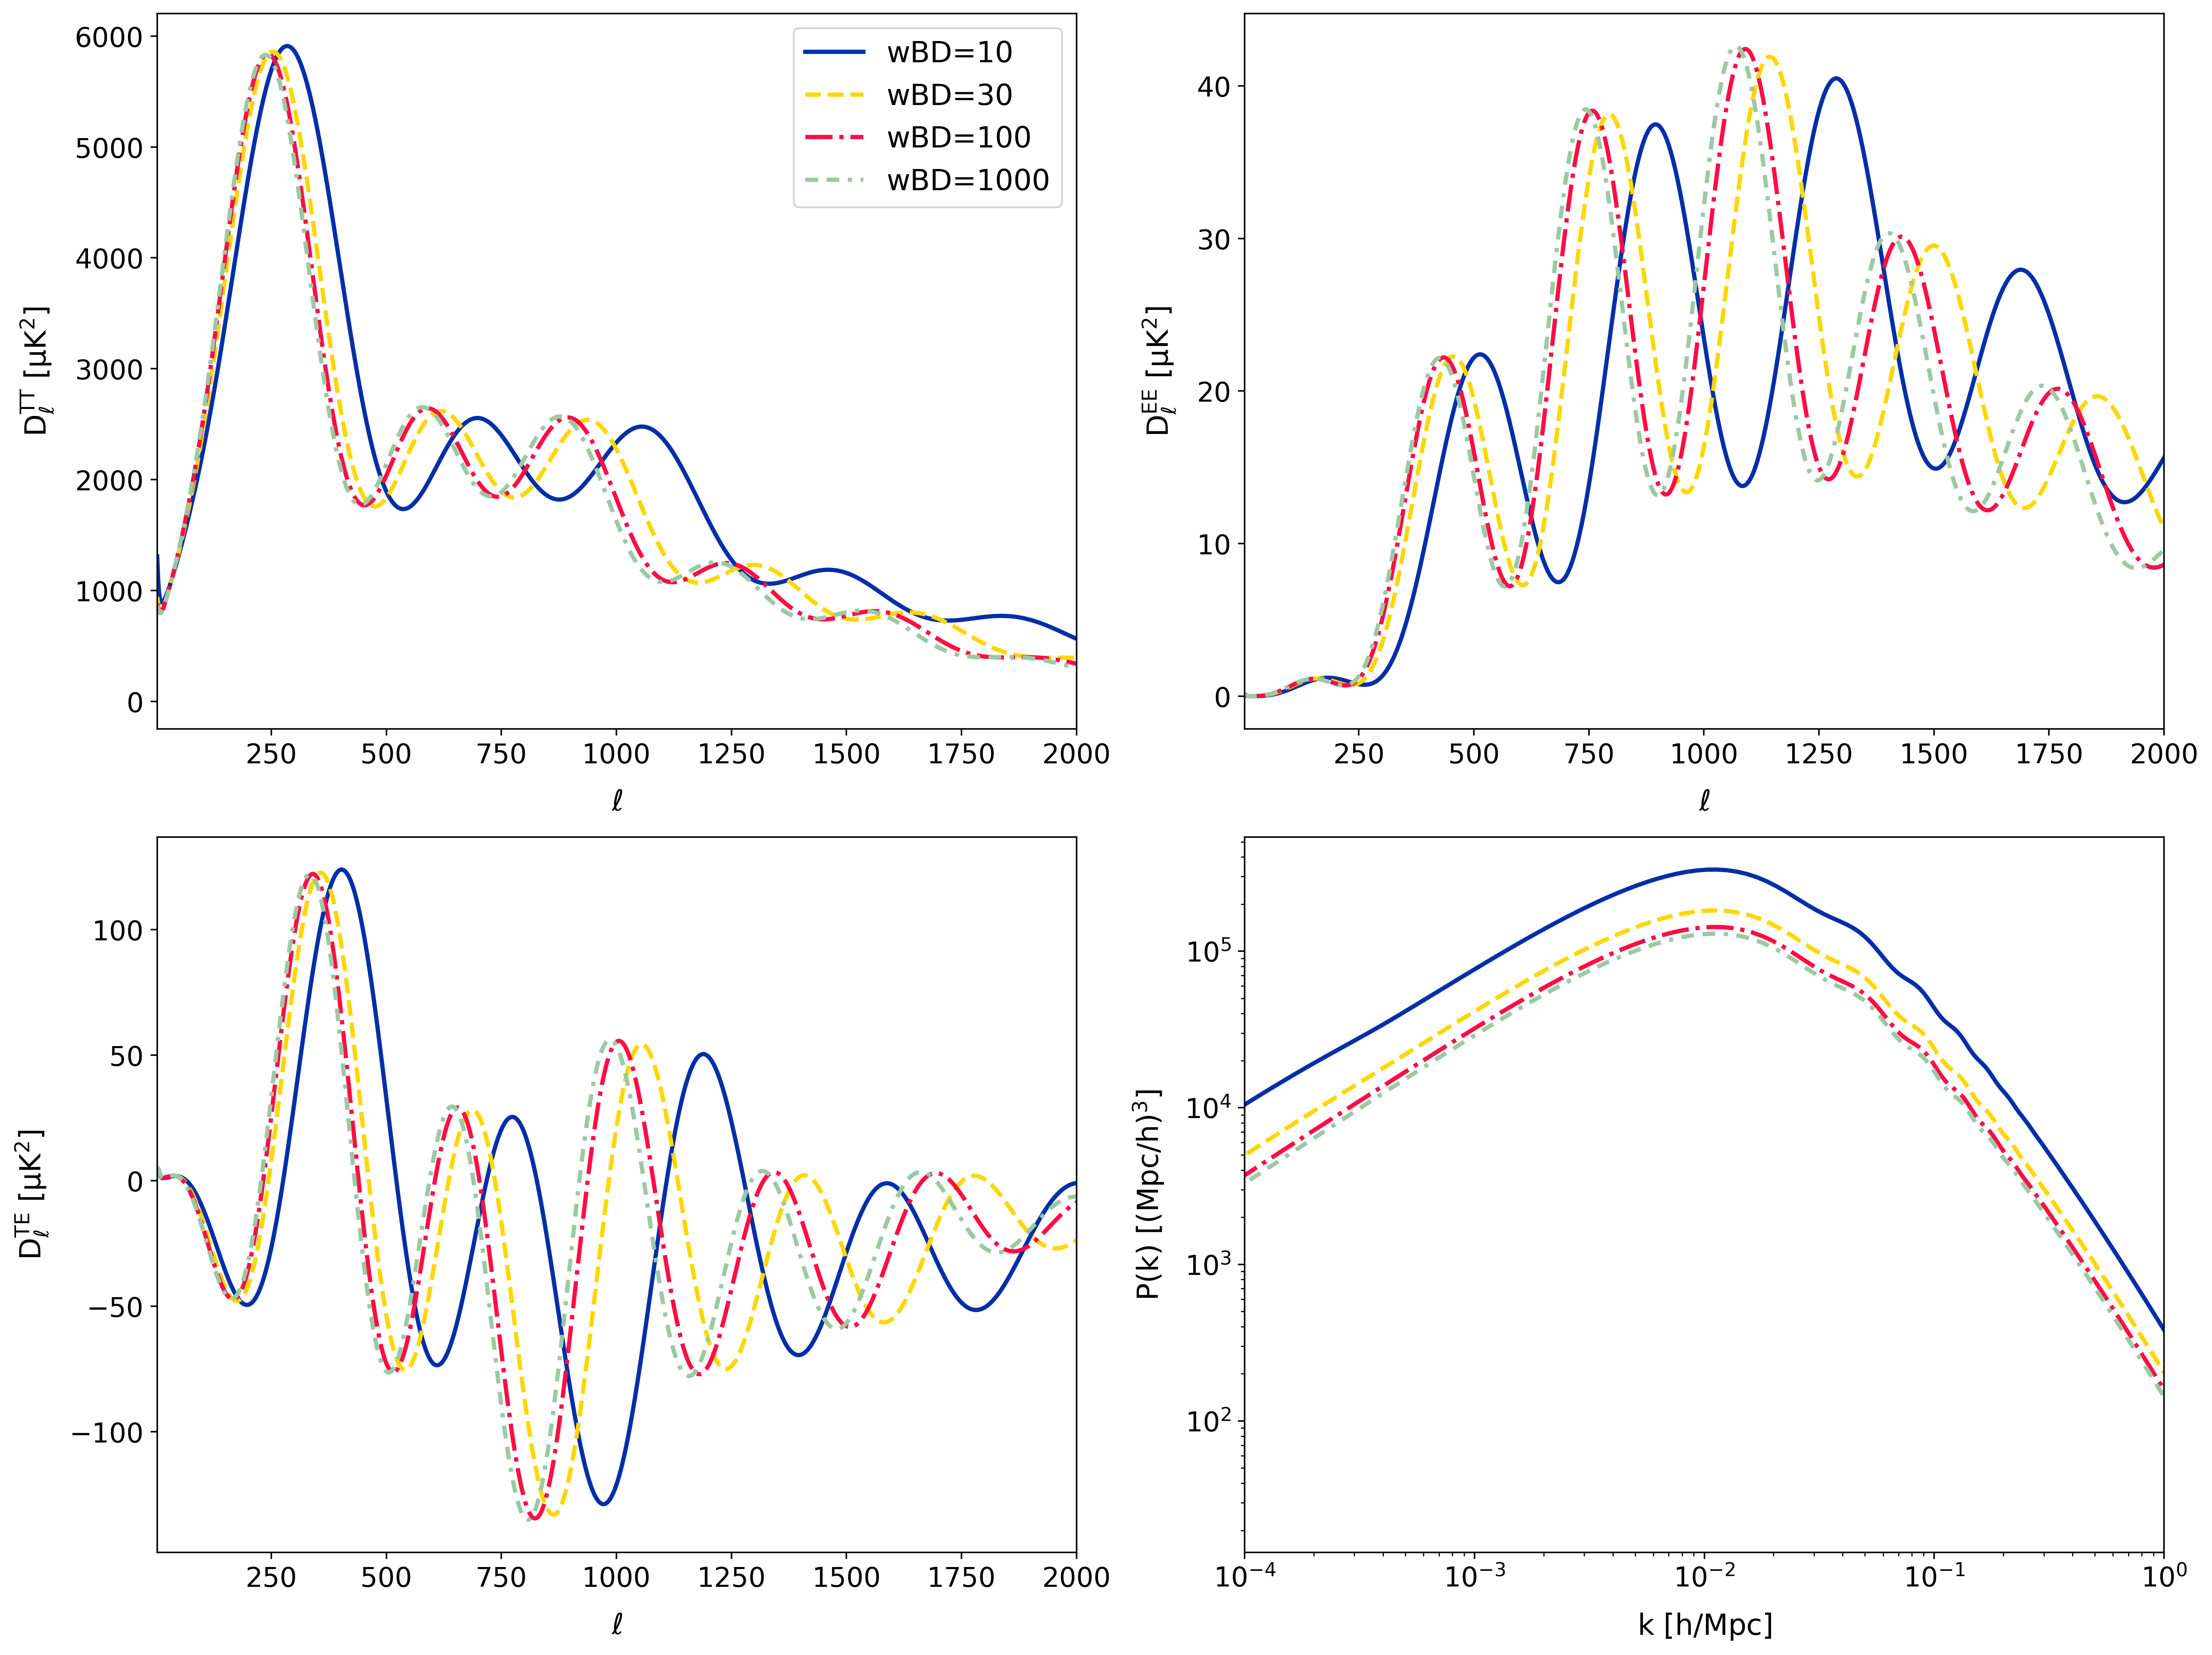

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


colors = ['#002FA7', '#FFD700',"#FF0D45", '#9CC9A3', ]
linestyles = ['-', '--', '-.', (0, (3, 2, 3, 2, 1, 2))]
wBD_list = [10, 30, 100, 1000]

for wBD, color, ls in zip(wBD_list, colors, linestyles):

    cls_camb_wBD = cls_camb_dict[wBD]* (2.7255e6)**2
    pk_camb_wBD = pk_camb_dict[wBD]
    k_camb_wBD = k_camb_dict[wBD]

    l = np.arange(cls_camb_wBD.shape[0])[2:3000]
    # --- TT ---
    axes[0,0].plot(l, cls_camb_wBD[2:3000, 0], color=color, ls=ls, label=f'wBD={wBD}')
    # --- EE ---
    axes[0,1].plot(l, cls_camb_wBD[2:3000, 1], color=color, ls=ls, label=f'wBD={wBD}')
    # --- TE ---
    axes[1,0].plot(l, cls_camb_wBD[2:3000, 3], color=color, ls=ls, label=f'wBD={wBD}')
    # --- P(k) ---
    axes[1,1].loglog(k_camb_wBD, pk_camb_wBD, color=color, ls=ls, label=f'wBD={wBD}')

# TT
axes[0,0].set_xlim([2, 2000])
axes[0,0].set_ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]')
axes[0,0].legend()
axes[0,0].set_xlabel(r'$\ell$')

# EE
axes[0,1].set_xlim([2, 2000])
axes[0,1].set_ylabel(r'$D_\ell^{EE}$ [$\mu K^2$]')
axes[0,1].set_xlabel(r'$\ell$')

# TE
axes[1,0].set_xlim([2, 2000])
axes[1,0].set_ylabel(r'$D_\ell^{TE}$ [$\mu K^2$]')
axes[1,0].set_xlabel(r'$\ell$')

# P(k)
axes[1,1].set_xlim([1e-4, 1])
axes[1,1].set_ylabel(r'$P(k)$ [$(Mpc/h)^3$]')
axes[1,1].set_xlabel(r'$k$ [$h/Mpc$]')

plt.tight_layout()
plt.show()
